### Sentiment Analysis RoBERTa 

In [1]:
pip install pandas scikit-learn transformers torch nltk


Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install 'transformers[torch]' -U



  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 61.7 MB/s eta 0:00:0000:0100:01
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 85.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.14.0
    Uninstalling sympy-1.14.0:
      Successfully uninstalled sympy-1.14.0
  Attempting uninstall: torch
    Found existing installation: torch 2.7.0
    Uninstalling torch-2.7.0:
      Successfully uninstalled torch-2.7.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3


In [3]:
!pip install simpletransformers


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Each epoch will have 387 steps.


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/387 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/387 [00:00<?, ?it/s]

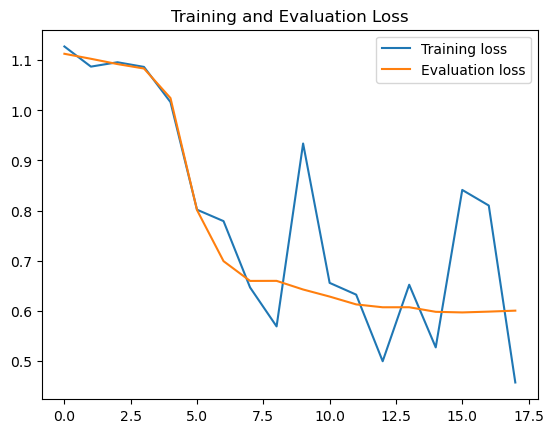

Running Evaluation:   0%|          | 0/14 [00:00<?, ?it/s]

Dev Set Evaluation Results:
{'mcc': 0.6230812473695639, 'eval_loss': 0.6001748527799334}


  0%|          | 0/1 [00:00<?, ?it/s]

RoBERTa Classification Report on Test Set:
              precision    recall  f1-score   support

    negative       0.67      0.67      0.67         6
     neutral       0.50      0.50      0.50         6
    positive       0.50      0.50      0.50         6

    accuracy                           0.56        18
   macro avg       0.56      0.56      0.56        18
weighted avg       0.56      0.56      0.56        18



In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
os.environ["WANDB_DISABLED"] = "true"

# Load datasets
train_df = pd.read_csv('/Users/annamironovich/Downloads/archive/train.csv', encoding="ISO-8859-1")
test_df = pd.read_csv('/Users/annamironovich/Downloads/sentiment-topic-test.tsv', sep='\t')

train_df = train_df[['text', 'sentiment']].dropna()
train_df = train_df.rename(columns={'text': 'text', 'sentiment': 'labels'})


train_df = train_df.sample(frac=0.5, random_state=42).reset_index(drop=True)


le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])
test_df['labels'] = le.transform(test_df['sentiment'])

train, dev = train_test_split(train_df, test_size=0.1, random_state=42)

# Model configuration
model_args = ClassificationArgs()

model_args.output_dir = '/tmp/roberta_model'
model_args.cache_dir = '/tmp/roberta_cache'
model_args.best_model_dir = '/tmp/roberta_model/best_model'
model_args.tensorboard_dir = '/tmp/roberta_logs'
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = True
model_args.num_train_epochs = 5
model_args.train_batch_size = 32
model_args.learning_rate = 4e-6
model_args.max_seq_length = 256
model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = 'eval_loss'
model_args.early_stopping_metric_minimize = True
model_args.early_stopping_patience = 2
model_args.evaluate_during_training_steps = 32
model_args.no_cache = True
model_args.use_multiprocessing = False
model_args.use_multiprocessing_for_evaluation = False
model_args.wandb_project = None  

steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print(f'Each epoch will have {steps_per_epoch:,} steps.')

# Initialize RoBERTa model
model = ClassificationModel(
    'roberta', 'distilroberta-base', 
    num_labels=len(le.classes_),
    args=model_args,
    use_cuda=torch.cuda.is_available()
)

#train
_, history = model.train_model(train, eval_df=dev)

# Plot
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()

# Evaluate
result, model_outputs, wrong_predictions = model.eval_model(dev)
print("Dev Set Evaluation Results:")
print(result)

# Predict on test set
predicted, _ = model.predict(test_df['sentence'].tolist())
test_df['predicted'] = predicted

# classification report
print("RoBERTa Classification Report on Test Set:")
print(classification_report(test_df['labels'], test_df['predicted'], target_names=le.classes_))


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
os.environ["WANDB_DISABLED"] = "true"

train_df = pd.read_csv('/Users/annamironovich/Downloads/archive/train.csv', encoding="ISO-8859-1")
test_df = pd.read_csv('/Users/annamironovich/Downloads/sentiment-topic-test.tsv', sep='\t')

train_df = train_df[['text', 'sentiment']].dropna()
train_df = train_df.rename(columns={'text': 'text', 'sentiment': 'labels'})


train_df = train_df.sample(frac=0.25, random_state=42).reset_index(drop=True)

le = LabelEncoder()
train_df['labels'] = le.fit_transform(train_df['labels'])
test_df['labels'] = le.transform(test_df['sentiment'])

train, dev = train_test_split(train_df, test_size=0.1, random_state=42)

# Model configuration
model_args = ClassificationArgs()

model_args.output_dir = '/tmp/roberta_model'
model_args.cache_dir = '/tmp/roberta_cache'
model_args.best_model_dir = '/tmp/roberta_model/best_model'
model_args.tensorboard_dir = '/tmp/roberta_logs'
model_args.overwrite_output_dir = True
model_args.evaluate_during_training = False
model_args.num_train_epochs = 2
model_args.train_batch_size = 16
model_args.learning_rate = 1e-5
model_args.max_seq_length = 128
model_args.use_early_stopping = False
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = 'eval_loss'
model_args.early_stopping_metric_minimize = True
model_args.early_stopping_patience = 2
model_args.evaluate_during_training_steps = 32




steps_per_epoch = int(np.ceil(len(train) / float(model_args.train_batch_size)))
print(f'Each epoch will have {steps_per_epoch:,} steps.')

# Initialize RoBERTa model
model = ClassificationModel(
    'roberta', 'distilroberta-base', 
    num_labels=len(le.classes_),
    args=model_args,
    use_cuda=torch.cuda.is_available()
)

# Train
_, history = model.train_model(train, eval_df=dev)



Each epoch will have 387 steps.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/12 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this war

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/387 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/387 [00:00<?, ?it/s]

In [24]:
result = model.train_model(train, eval_df=dev)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/12 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/387 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/387 [00:00<?, ?it/s]

In [26]:
train_loss = model.train_model(train)
print(f"Final training loss: {train_loss}")


  0%|          | 0/12 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid dea

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/387 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/387 [00:00<?, ?it/s]

Final training loss: (774, 0.40779190655865105)


In [27]:
result, model_outputs, wrong_predictions = model.eval_model(dev)
print("Dev Set Evaluation Results:")
print(result)

  0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
TOKENIZERS_PARALLELISM	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable =(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `

Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

Dev Set Evaluation Results:
{'mcc': 0.6788904415315209, 'eval_loss': 0.5441117797579084}


In [28]:
# Predict on test set
predicted, _ = model.predict(test_df['sentence'].tolist())
test_df['predicted'] = predicted


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISMTo disable this warning, you can either:
=(true | false)
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#classification report
print("RoBERTa Classification Report on Test Set:")
print(classification_report(test_df['labels'], test_df['predicted'], target_names=le.classes_))


RoBERTa Classification Report on Test Set:
              precision    recall  f1-score   support

    negative       0.80      0.67      0.73         6
     neutral       0.60      0.50      0.55         6
    positive       0.62      0.83      0.71         6

    accuracy                           0.67        18
   macro avg       0.67      0.67      0.66        18
weighted avg       0.68      0.67      0.66        18



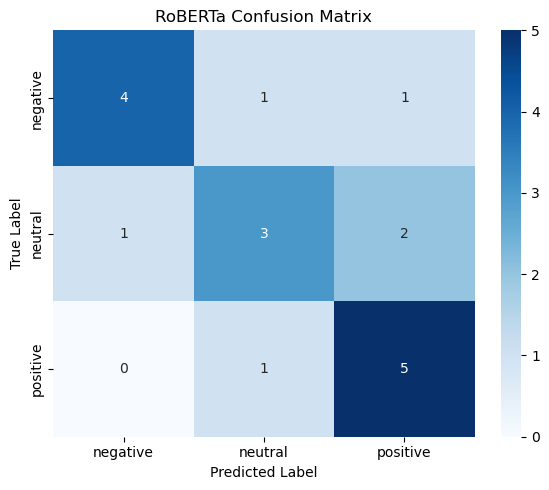

In [48]:
cm = confusion_matrix(test_df['true_label_encoded'], test_df['predicted_label_encoded'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("RoBERTa Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

### Sentiment Analysis VADER

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.metrics import classification_report

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    score = sid.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply VADER to test set
test_df['vader_pred'] = test_df['sentence'].apply(get_vader_sentiment)
test_df['vader_pred_label'] = le.transform(test_df['vader_pred'])

print("VADER Sentiment Classification Report:")
print(classification_report(test_df['label'], test_df['vader_pred_label'], target_names=le.classes_))


VADER Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.17      0.29         6
     neutral       0.20      0.17      0.18         6
    positive       0.25      0.50      0.33         6

    accuracy                           0.28        18
   macro avg       0.48      0.28      0.27        18
weighted avg       0.48      0.28      0.27        18



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/annamironovich/nltk_data...


#### Customised VADER

In [40]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

custom_words = {
    "incredible": 2.0,
    "unbelievable": 2.5,
    "swept": 1.5,
    "dragged": -1.5,
    "confusing": -1.0,
    "grows": 1.5,
    "wild": 1.2,
    "fell apart": -2.5,
    "decent": 0.5,
    "annoying": -2.0,
    "genuine": 1.8,
    "clicked": -1.2,
    "spark": 1.2,
    "hype": -0.8,
    "disappointing": -2.0,
    "coaster": -2.5,
    "alive": 1.5,
    "roar": 1.0,
    "jumping": 1.5,
    "hard to care": -1.8,
    "scribbled": -1.5
}
sid.lexicon.update(custom_words)

def get_custom_vader_sentiment(text):
    score = sid.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

test_df = pd.DataFrame({'sentence': sentences, 'true_label': true_labels})
test_df['vader_pred'] = test_df['sentence'].apply(get_custom_vader_sentiment)


le = LabelEncoder()
test_df['true_label_encoded'] = le.fit_transform(test_df['true_label'])
test_df['vader_pred_encoded'] = le.transform(test_df['vader_pred'])

# --- Classification Report ---
print("Custom VADER Sentiment Classification Report:")
print(classification_report(test_df['true_label_encoded'], test_df['vader_pred_encoded'], target_names=le.classes_))




Custom VADER Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.50      0.17      0.25         6
     neutral       0.67      0.33      0.44         6
    positive       0.46      1.00      0.63         6

    accuracy                           0.50        18
   macro avg       0.54      0.50      0.44        18
weighted avg       0.54      0.50      0.44        18



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/annamironovich/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
